In [1]:
import numpy as np

In [ ]:
c = np.array([1, 3, 5,-2, 6, 2,-4, 9,10, 1, 4,-6])
a = np.array([1, 2, 6, 3,-3, 4,-2,-8,-5,-7, 7,-1])
b = np.array([6, 4, 1, 8, 9, 3, 2,12,10,11,0.9,5])
d = [-1 if i<0 else 1 for i in c ]
#print(d)
-np.corrcoef(a*d,b)[0,1]

0.9781826740728177

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#  %cd /content/gdrive/My Drive

/content/gdrive/My Drive


In [ ]:
# !pip install lime

     |████████████████████████████████| 275 kB 4.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=ad1be2f0ad52d2e8adb472de03d84073d68fc2a5cb7f7c84697199d1553b5a96
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# !pip install shap

     |████████████████████████████████| 356 kB 5.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491648 sha256=755352eccb5136fc882aeb2a867166c3452f5bd7a695ade3abde3b98747d9de3
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [2]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import lime
import shap
import matplotlib as plot
import sklearn.metrics
import sklearn.datasets
from sklearn.preprocessing import StandardScaler




/home/teadem/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
def loadDataset(dataset):
    if dataset == "boston":
        boston = sklearn.datasets.load_boston()
        boston_df = pd.DataFrame(boston['data'] )
        boston_df.columns = boston['feature_names']
        boston_df['PRICE']= boston['target']

        y = boston_df['PRICE']
        X = boston_df.iloc[:,0:13]
        return X, y
    elif dataset == "superconductivity":
        df = pd.read_csv("train.csv")
        y = df['critical_temp']
        X = df.drop('critical_temp',axis=1)

        return X,y
    elif dataset == "diabetes":
        diabetes = sklearn.datasets.load_diabetes()
        diabetes_df = pd.DataFrame(diabetes.data )
        diabetes_df.columns = diabetes.feature_names
        diabetes_df['target']= diabetes['target']

        y = diabetes_df['target']
        X = diabetes_df.drop('target',axis=1)
        return X, y
    else: 
        return None

In [4]:

def split_train_test(X,y,test_size=0.3,randomstate=42,scale=False):
    if scale == False:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=randomstate)
        return X_train,X_test,y_train,y_test
    else:
        sc = StandardScaler()
        X_scaled = sc.fit_transform(X)
        y_scaled = sc.fit_transform(y)

        return train_test_split(X_scaled,y_scaled,test_size=test_size,random_state=randomstate)


In [5]:
def train_model(model, X,y):
    if model == "Linear Regression":
        lr = LinearRegression()
        lr.fit(X,y)
        return lr
    elif model == "Random Forest Regressor":
        rf_r = RandomForestRegressor()
        rf_r.fit(X,y)
        return rf_r
    elif model == "SVR":
        svr = SVR()
        svr.fit(X,y)
        return svr
    else:
        return None


In [6]:

def Explanation(explainer,model,X,X_ref):
    if explainer == "SHAP":
        exp = shap.Explainer(model.predict, X_ref)
        shap_vals = exp(X)
        base_val = shap_vals.base_values 
        return shap_vals,base_val
    elif explainer == "Kernel SHAP":
        exp = shap.KernelExplainer(model.predict, X_ref)
        shap_vals = exp.shap_values(X)
        expected_val = exp.expected_value
        return shap_vals,expected_val
    elif explainer == "Tree SHAP":
        exp = shap.TreeExplainer(model,X_ref)
        shap_vals = exp(X)
        return shap_vals
    elif explainer == "LIME":
        X_np= X.to_numpy()
        featureNames=X.columns
        lime_exp = lime.lime_tabular.LimeTabularExplainer(
            X_np,
            feature_names=featureNames ,
            class_names=['feature_names'], 
            verbose=True, 
            mode='regression') 
        exp_lime = []
        for x in X:
            ex = lime_exp.explain_instance(x, 
                model.predict, num_features=len(featureNames))
            exp_lime.append(x)
        return exp_lime
    elif explainer == "LIME-SHAP":
        exp_lime = []
        X_np= X.to_numpy()
        featureNames=X.columns
        No_features = len(featureNames)
        for x in X_np:
          lime_explainer_shap = shap.other.LimeTabular(model.predict,x,mode = 'regression')
          lime_attribs = lime_explainer_shap.attributions(x,num_features=No_features)
    else:
        return None


In [7]:
def visualize(model,X, shap_value,type_of_Vis,local_global):
    if local_global == "local":
        shap.initjs()
        if type_of_Vis == "force":
            shap.plots.force(shap_value)
        
    elif local_global == "global":
        if type_of_Vis == "plot bar":
            shap.plots.bar(shap_value)
        elif type_of_Vis == "heatmap":
            shap.plots.heatmap(shap_value)
        elif type_of_Vis == "summary plot":
            shap.summary_plot(shap_value, X)


In [8]:
import matplotlib.pyplot as pp
def plot(x):
  pp.plot(x,'-o')
  pp.show()

In [9]:
def faithfulness_metric(model, x, coefs, base):
    predt = model.predict(np.transpose(x.reshape(-1,1)))
    ar = np.argsort(coefs) 
    pred_ts = np.zeros(x.shape[0])
    diff = []
    for ind in np.nditer(ar):
        x_copy = x.copy()
        d = x_copy[ind]-base[ind]
        if d<0:
            diff.append(-1)
        else:
            diff.append(1)
        x_copy[ind] = base[ind]
        x_copy_ts = model.predict(np.transpose(x_copy.reshape(-1,1)))
        pred_ts[ind] = x_copy_ts
    
    return -np.corrcoef(np.array(diff)*coefs, pred_ts)[0,1]


In [10]:
def faithfulness_metric_new(model, x, coefs, base):
    predt = model.predict(np.transpose(x.reshape(-1,1)))
    ar = np.argsort(coefs) 
    pred_ts = np.zeros(x.shape[0])
    diff = []
    for ind in np.nditer(ar):
        x_copy = x.copy()
        d = x_copy[ind]-base[ind]
        if d<0:
            diff.append(-1)
        else:
            diff.append(1)
        x_copy[ind] = base[ind]
        x_copy_ts = model.predict(np.transpose(x_copy.reshape(-1,1)))
        pred_ts[ind] = x_copy_ts - predt
    
    return -np.corrcoef(coefs, pred_ts)[0,1]

In [11]:
def monotonicity_metric(model, x, coefs, base):
    predict_ = model.predict(np.transpose(x.reshape(-1,1)))
    x_copy = base.copy()
    ar = np.argsort(coefs)
    isPos = [False for i in range(len(ar))]
    pred_tss = np.zeros(x.shape[0])
    
    for ind in np.nditer(ar):
        if coefs[ind]<0:
            isPos[ind] = False
        else:
            isPos[ind] = True
        x_copy[ind] = x[ind]
        x_copy_pr = model.predict(np.transpose(x_copy.reshape(-1,1)))
        pred_tss[ind] = x_copy_pr
    diff = np.diff(pred_tss[ar])
    final_ = []
    for i in range(len(diff)):
        if isPos[i] == False and diff[i] < 0:
            final_.append(True)
        elif isPos[i] == True and diff[i] >=0:
            final_.append(True)
        else:
            final_.append(False)
    return any(final_)


In [ ]:
# X,y = loadDataset("boston")
# X_new = X.drop(columns=['ZN','CHAS','RAD'])
# cols = X.columns
# base1 = X[cols].mean()
# base1['ZN'] = int(round(X['ZN'].mean()))
# base1['CHAS'] = 0
# base1['RAD'] = int(round(X['RAD'].mean()))
# base = base1.values
# base1
# (X.to_numpy())[3:,]


In [12]:
def metrics(model,X,shap_val,explainer_type,metrics_type,dataset):
    cols = X.columns
    if dataset == "boston":
      base1 = X[cols].mean()
      base1['ZN'] = int(round(X['ZN'].mean()))
      base1['CHAS'] = 0
      base1['RAD'] = int(round(X['RAD'].mean()))
      base = base1.values
    else:
      base = X[cols].mean().values
    if metrics_type == "faithfulness":
        faithfulness = []
        if explainer_type == "shap":
            for i in range(X.shape[0]):
                x = np.array(X.iloc[i,:])
                # print(shap_val[i])
                coefs = shap_val[i].values
                f = faithfulness_metric_new(model, x, coefs, base)
                # print(f)
                faithfulness.append(f)
        elif explainer_type == "lime":
            for i in range(X.shape[0]):
                x = np.array(X.iloc[i,:])
                coefs = np.array(shap_val)
                f = faithfulness_metric_new(model, x, coefs, base)
                # print(f)
                faithfulness.append(f)
        plot(faithfulness)
        return np.array(faithfulness).mean()
    elif metrics_type == "monotonicity":
        monotonicity = []
        if explainer_type == "shap":
            for i in range(X.shape[0]):
                x = np.array(X.iloc[i,:])
                coefs = shap_val.values[i]
                f = monotonicity_metric(model, x, coefs, base)
                monotonicity.append(f)
        elif explainer_type == "lime":
            for i in range(X.shape[0]):
                x = np.array(X.iloc[i,:])
                coefs = np.array(shap_val)
                f = monotonicity_metric(model, x, coefs, base)
                monotonicity.append(f)
        return monotonicity

In [13]:
def Main(dataset):
  X,y = loadDataset(dataset)
  X_train,X_test,y_train,y_test = train_test_split(X,y)
  LR_model = train_model("Linear Regression",X_train,y_train)
  RF_model = train_model("Random Forest Regressor",X_train,y_train)

  X100 = shap.utils.sample(X, 100)
  LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
  LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[50:,],X100)
  # LR_lime1 = Explanation("lime",LR_model,X_test,X100)
  # LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)

  RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[100:,],X100)
  RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[50:,],X100)
  # RF_lime1 = Explanation("lime",RF_model,X_test,X100)
  # RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)

  faithfulness_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)

  monotonicity_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
  monotonicity_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_LR_shap)
  print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_LR_lime)
  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_RF_shap)
  print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_RF_lime)
  print("====================================================================")
  print(monotonicity_LR_shap)
  print("====================================================================")
  # print(monotonicity_LR_lime.any())
  print("====================================================================")
  print(monotonicity_RF_shap)
  print("====================================================================")
  # print(monotonicity_RF_lime.any())
  print("====================================================================")
#monotonicity_RF_lime,faithfulness_LR_lime,faithfulness_RF_lime,monotonicity_LR_lime
  return faithfulness_RF_shap,monotonicity_LR_shap,monotonicity_RF_shap,faithfulness_LR_shap

Using 506 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/27 [00:00<?, ?it/s]

Using 506 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/27 [00:00<?, ?it/s]

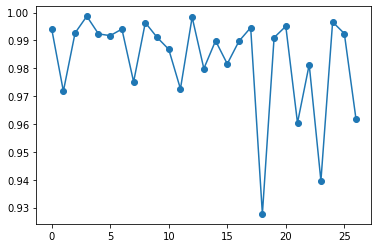

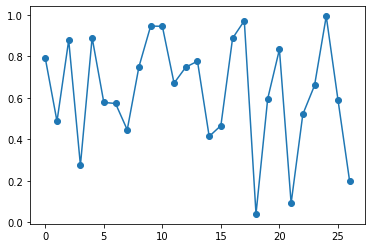

faithfulness for SHAP explainer for Linear regression 0.9828780057539624
faithfulness for SHAP explainer for Linear regression 0.6306657283747704
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [ ]:
# x1,x2,x3,x4,
x5,x6,x7,x8 = Main("boston")

In [ ]:
# x1,x2,x3,x4,
x5,x6,x7,x8 = Main("superconductivity")

Permutation explainer: 5217it [09:18,  9.21it/s]
Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5216 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
X,y = loadDataset("boston")
X_train,X_test,y_train,y_test = train_test_split(X,y)
# LR_model = train_model("Linear Regression",X_train,y_train)
# X100 = shap.utils.sample(X, 1000)
# LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
# LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)
# LR_lime
len(X.columns)

13

In [ ]:
faithfulness_LR_shap = metrics(model=LR_model,X=X_test,shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_LR_lime = metrics(model=LR_model,X=X_test,shap_val=LR_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap = metrics(model=RF_model,X=X_test,shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_lime = metrics(model=RF_model,X=X_test,shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)

  monotonicity_LR_shap = metrics(model=LR_model,X=X_test,shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_LR_lime = metrics(model=LR_model,X=X_test,shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
  monotonicity_RF_shap = metrics(model=RF_model,X=X_test,shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_RF_lime = metrics(model=RF_model,X=X_test,shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)

  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_LR_shap)
  print("====================================================================")
  # print(faithfulness_LR_lime)
  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_RF_shap)
  print("====================================================================")
  # print(faithfulness_RF_lime)
  print("====================================================================")
  print(monotonicity_LR_shap)
  print("====================================================================")
  # print(monotonicity_LR_lime)
  print("====================================================================")
  print(monotonicity_RF_shap)
  print("====================================================================")
  # print(monotonicity_RF_lime)
  print("====================================================================")
#monotonicity_RF_lime,faithfulness_LR_lime,faithfulness_RF_lime,monotonicity_LR_lime

In [ ]:
# x1,x2,x3,x4,
x5,x6,x6,x7,x8 = Main("superconductivity")

Permutation explainer: 5217it [14:15,  6.03it/s]                          


  0%|          | 0/5266 [00:00<?, ?it/s]

Permutation explainer:  41%|████      | 2139/5216 [43:27<1:03:49,  1.24s/it]

In [ ]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

In [ ]:
max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Epoch 1/15
782/782 [==============================] - 225s 284ms/step - loss: 0.4422 - accuracy: 0.7865 - val_loss: 0.3611 - val_accuracy: 0.8398
Epoch 2/15
782/782 [==============================] - 222s 284ms/step - loss: 0.2530 - accuracy: 0.8993 - val_loss: 0.3876 - val_accuracy: 0.8364
Epoch 3/15
782/782 [==============================] - 220s 281ms/step - loss: 0.1633 - accuracy: 0.9393 - val_loss: 0.4321 - val_accuracy: 0.8263
Epoch 4/15
782/782 [==============================] - 222s 284ms/step - loss: 0.1016 - accuracy: 0.9641 - val_loss: 0.6316 - val_accuracy: 0.8196
Epoch 5/15
782/782 [==============================] - 222s 283ms/step - loss: 0.0772 - accuracy: 0.9730 - val_loss: 0.6295 - val_accuracy: 0.8201
Epoch 6/15
782/782 [==================

In [ ]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, x_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test[:10])

# init the JS visualization code
shap.initjs()

# transform the indexes to words
import numpy as np
words = imdb.get_word_index()
num2word = {}
for w in words.keys():
    num2word[words[w]] = w
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
shap.force_plot(explainer.expected_value[0], shap_values[0][0], x_test_words[0])



NameError: ignored

In [ ]:
X,y = loadDataset("boston")
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [ ]:
X_new = X.drop(columns=['ZN','CHAS','RAD'])
mean = X_new.mean(axis=0)
std = X_new.std(axis=0)

